#  Import Libraries

In [1]:
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from pylab import rcParams
from sklearn import metrics, preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import Model, layers, models, optimizers, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import (
    LSTM,
    Dense,
    Dropout,
    Input,
    RepeatVector,
    TimeDistributed,
)

# Load Data

In [5]:
train = pd.read_csv("2_train.csv")
test = pd.read_csv("2_test.csv")

train.head()

,Unnamed: 0,Timestamp,INFO-01-Request,INFO-01-Success,INFO-01-Fail,LOGIN-01-Request,LOGIN-01-Success,LOGIN-01-Fail,LOGIN-02-Request,LOGIN-02-Success,...,MENU-02-Fail,MENU-03-Request,MENU-03-Success,MENU-03-Fail,MENU-04-Request,MENU-04-Success,MENU-04-Fail,STREAM-01-Session,STREAM-02-Session,STREAM-03-Session
0,0,20170101_0000-0005,652.933035,652.933035,0.0,4405.0,4292.0,113.0,870.019741,833.147889,...,51.0,6477.0,6418.0,59.0,6518.0,6472.0,46.0,230.070777,293.673826,317.0
1,1,20170101_0005-0010,652.933035,652.933035,0.0,2260.0,2208.0,52.0,870.019741,833.147889,...,21.0,2891.0,2860.0,31.0,2765.0,2747.0,18.0,230.070777,293.673826,195.0
2,2,20170101_0010-0015,652.933035,652.933035,0.0,1648.0,1623.0,25.0,870.019741,833.147889,...,33.0,3884.0,3842.0,42.0,3990.0,3934.0,56.0,230.070777,293.673826,171.0
3,3,20170101_0015-0020,652.933035,652.933035,0.0,1407.0,1387.0,20.0,870.019741,833.147889,...,30.0,2718.0,2685.0,33.0,2561.0,2525.0,36.0,230.070777,293.673826,158.0
4,4,20170101_0020-0025,652.933035,652.933035,0.0,1374.0,1351.0,23.0,870.019741,833.147889,...,28.0,2450.0,2409.0,41.0,2389.0,2375.0,14.0,230.070777,293.673826,166.0


In [6]:
train.columns

Index(['Unnamed: 0', 'Timestamp', 'INFO-01-Request', 'INFO-01-Success',
       'INFO-01-Fail', 'LOGIN-01-Request', 'LOGIN-01-Success', 'LOGIN-01-Fail',
       'LOGIN-02-Request', 'LOGIN-02-Success', 'LOGIN-02-Fail',
       'LOGIN-03-Request', 'LOGIN-03-Success', 'LOGIN-03-Fail',
       'LOGIN-04-Request', 'LOGIN-04-Success', 'LOGIN-04-Fail',
       'LOGIN-05-Request', 'LOGIN-05-Success', 'LOGIN-05-Fail',
       'MENU-01-Request', 'MENU-01-Success', 'MENU-01-Fail', 'MENU-02-Request',
       'MENU-02-Success', 'MENU-02-Fail', 'MENU-03-Request', 'MENU-03-Success',
       'MENU-03-Fail', 'MENU-04-Request', 'MENU-04-Success', 'MENU-04-Fail',
       'STREAM-01-Session', 'STREAM-02-Session', 'STREAM-03-Session'],
      dtype='object')

In [7]:
train.drop(['Unnamed: 0', 'Timestamp'], inplace=True, axis=1)
test.drop(['Unnamed: 0', 'Timestamp'], inplace=True, axis=1)

In [8]:
train

,INFO-01-Request,INFO-01-Success,INFO-01-Fail,LOGIN-01-Request,LOGIN-01-Success,LOGIN-01-Fail,LOGIN-02-Request,LOGIN-02-Success,LOGIN-02-Fail,LOGIN-03-Request,...,MENU-02-Fail,MENU-03-Request,MENU-03-Success,MENU-03-Fail,MENU-04-Request,MENU-04-Success,MENU-04-Fail,STREAM-01-Session,STREAM-02-Session,STREAM-03-Session
0,652.933035,652.933035,0.0,4405.0,4292.0,113.0,870.019741,833.147889,36.871851,870.035902,...,51.0,6477.0,6418.0,59.0,6518.0,6472.0,46.0,230.070777,293.673826,317.0
1,652.933035,652.933035,0.0,2260.0,2208.0,52.0,870.019741,833.147889,36.871851,870.035902,...,21.0,2891.0,2860.0,31.0,2765.0,2747.0,18.0,230.070777,293.673826,195.0
2,652.933035,652.933035,0.0,1648.0,1623.0,25.0,870.019741,833.147889,36.871851,870.035902,...,33.0,3884.0,3842.0,42.0,3990.0,3934.0,56.0,230.070777,293.673826,171.0
3,652.933035,652.933035,0.0,1407.0,1387.0,20.0,870.019741,833.147889,36.871851,870.035902,...,30.0,2718.0,2685.0,33.0,2561.0,2525.0,36.0,230.070777,293.673826,158.0
4,652.933035,652.933035,0.0,1374.0,1351.0,23.0,870.019741,833.147889,36.871851,870.035902,...,28.0,2450.0,2409.0,41.0,2389.0,2375.0,14.0,230.070777,293.673826,166.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105115,2260.000000,2260.000000,0.0,2213.0,1906.0,307.0,2212.000000,1918.000000,294.000000,2215.000000,...,58.0,3777.0,3735.0,42.0,3832.0,3787.0,45.0,432.000000,584.000000,222.0
105116,2139.000000,2139.000000,0.0,2186.0,1926.0,260.0,2187.000000,1924.000000,263.000000,2186.000000,...,43.0,3647.0,3593.0,54.0,3633.0,3566.0,67.0,436.000000,583.000000,223.0
105117,2170.000000,2170.000000,0.0,2330.0,2045.0,285.0,2327.000000,2030.000000,297.000000,2328.000000,...,65.0,3932.0,3879.0,53.0,3960.0,3893.0,67.0,441.000000,602.000000,244.0
105118,2283.000000,2283.000000,0.0,2663.0,2338.0,325.0,2666.000000,2375.000000,291.000000,2665.000000,...,70.0,4220.0,4141.0,79.0,4170.0,4114.0,56.0,446.000000,606.000000,277.0


In [9]:
n_features = train.shape[1]
print(n_features)

33


# standardization

In [10]:
scaler = preprocessing.StandardScaler().fit(train)

train_scaled = scaler.transform(train)
test_scaled = scaler.transform(test)

# Transform to Series Data, train test split

In [11]:
train_set = train_scaled.reshape(len(train_scaled), 1, n_features)[len(train_scaled) // 10 * 7 :]
valid_set = train_scaled.reshape(len(train_scaled), 1, n_features)[: len(train_scaled) // 10 * 7]
test_set = test_scaled.reshape(len(test_scaled), 1, n_features)

# Training LSTM Autoencoder

In [12]:
def autoencoder_model(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = LSTM(
        140,
        activation="relu",
        return_sequences=True,
        kernel_regularizer=regularizers.l2(0.00),
    )(inputs)

    L2 = LSTM(70, activation="relu", return_sequences=False)(L1)
    L3 = RepeatVector(X.shape[1])(L2)
    L4 = LSTM(70, activation="relu", return_sequences=True)(L3)
    L5 = LSTM(140, activation="relu", return_sequences=True)(L4)
    output = TimeDistributed(Dense(X.shape[2]))(L5)
    model = Model(inputs=inputs, outputs=output)
    return model

In [13]:
model = autoencoder_model(train_set)
model.compile(optimizer="adam", loss="mse")
model.summary()

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2022-05-04 15:18:00.890690: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-04 15:18:00.890919: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1, 33)]           0         
                                                                 
 lstm (LSTM)                 (None, 1, 140)            97440     
                                                                 
 lstm_1 (LSTM)               (None, 70)                59080     
                                                                 
 repeat_vector (RepeatVector  (None, 1, 70)            0         
 )                                                               
                                                                 
 lstm_2 (LSTM)               (None, 1, 70)             39480     
                                                                 
 lstm_3 (LSTM)               (None, 1, 140)            118160    
                                                             

In [14]:
model = autoencoder_model(train_set)
model.compile(optimizer="adam", loss="mse")

nb_eprochs = 1000
batch_size = 32
callbacks = [EarlyStopping(monitor="val_loss", patience=2)]
history = model.fit(
    train_set,
    train_set,
    epochs=nb_eprochs,
    batch_size=batch_size,
    validation_data=(valid_set, valid_set),
    callbacks=callbacks,
)

Epoch 1/1000


2022-05-04 15:18:04.533944: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-05-04 15:18:05.313024: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


986/986 [==============================] - ETA: 0s - loss: 0.1498

2022-05-04 15:18:35.964587: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


986/986 [==============================] - 53s 52ms/step - loss: 0.1498 - val_loss: 0.2517
Epoch 2/1000
986/986 [==============================] - 52s 53ms/step - loss: 0.0384 - val_loss: 0.1762
Epoch 3/1000
986/986 [==============================] - 51s 52ms/step - loss: 0.0256 - val_loss: 0.1571
Epoch 4/1000
986/986 [==============================] - 51s 52ms/step - loss: 0.0186 - val_loss: 0.1511
Epoch 5/1000
986/986 [==============================] - 51s 52ms/step - loss: 0.0144 - val_loss: 0.1472
Epoch 6/1000
986/986 [==============================] - 51s 52ms/step - loss: 0.0249 - val_loss: 0.1262
Epoch 7/1000
986/986 [==============================] - 51s 52ms/step - loss: 0.0155 - val_loss: 0.1203
Epoch 8/1000
986/986 [==============================] - 52s 53ms/step - loss: 0.0114 - val_loss: 0.1206
Epoch 9/1000
986/986 [==============================] - 55s 55ms/step - loss: 0.0107 - val_loss: 0.1163
Epoch 10/1000
986/986 [==============================] - 60s 61ms/step - loss

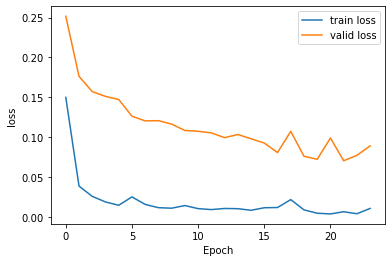

In [15]:
plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="valid loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("loss")
plt.show()

# Threshold

In [16]:
loss = model.predict(valid_set) - valid_set

2022-05-04 15:43:44.818230: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [17]:
loss = loss.reshape(loss.shape[0], loss.shape[2])

In [18]:
all_loss = []
for i in range(len(loss)):
    all_loss.append(np.sqrt(np.mean(loss[i] ** 2)))

In [21]:
threshold = np.mean(all_loss) + 1 * np.std(all_loss)
print(threshold)

0.4192946358002274


In [20]:
threshold = 0.5

# predict

In [22]:
best = pd.read_csv("autoencoder_best.csv")
test_predictions = model.predict(test_set)

2022-05-04 15:44:31.408656: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [23]:
predict = []
for i in range(len(test_set)):
    if np.sqrt(np.mean((test_set - test_predictions)[i] ** 2)) > threshold:
        predict.append(1)
    else:
        predict.append(0)

In [24]:
pd.DataFrame(predict).value_counts()

0    94925
1    10195
dtype: int64

In [26]:
predict_ = pd.DataFrame(predict, columns=["Prediction_"])

In [27]:
cont = pd.concat([predict_, best["Prediction"]], axis=1)

In [28]:
cont.head()

,Prediction_,Prediction
0,1,0.0
1,0,0.0
2,0,0.0
3,0,0.0
4,0,0.0


In [29]:
TT = cont[cont["Prediction_"] != cont["Prediction"]]
TT[TT["Prediction_"] == 0]

,Prediction_,Prediction
19,0,1.0
20,0,1.0
21,0,1.0
22,0,1.0
23,0,1.0
...,...,...
105020,0,NaN
105021,0,NaN
105024,0,NaN
105029,0,NaN


In [30]:
TT.shape

(80431, 2)

In [31]:
predict = []
for i in range(len(test_set)):
    if np.sqrt(np.mean((test_set - test_predictions)[i] ** 2)) > threshold:
        predict.append(1)
    else:
        predict.append(0)
pd.DataFrame(predict).value_counts()
predict_ = pd.DataFrame(predict, columns=["Prediction"])
predict_.shape

(105120, 1)

In [32]:
predict_.to_csv("2predict.csv", mode="w")

In [33]:
predict_.value_counts()

Prediction
0             94925
1             10195
dtype: int64